In [3]:
import numpy as np
import pandas as pd
import pickle
import os
import pdb
from tqdm import tqdm

import scipy.stats as stats
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from joblib import Parallel, delayed

# from gimmemotifs.motif import Motif, read_motifs

np.random.seed(97)

In [4]:
def create_fasta(seqs, file_path):
    with open(file_path, "w+") as f:
        for i, seq in enumerate(seqs):
            f.write(f">{i}\n")
            f.write(f"{seq}\n")

In [5]:
def get_all_motifs_from_meme_file(meme_file):
    meme_file = open(meme_file, "r").readlines()
    all_motifs = []

    for i, line in enumerate(meme_file):
        if line.startswith("MOTIF "):
            j = i
            motif_name = meme_file[j].split(" ")[1]
            while(not meme_file[j].startswith("letter-probability matrix")):
                j += 1
            length = int(meme_file[j].split(" ")[5])
            j += 1

            pwm = []
            while(j < len(meme_file) and (not meme_file[j].startswith("MOTIF")) and len(meme_file[j].strip()) > 0):
                pos_prob = [float(i.strip()) for i in meme_file[j].strip().split()]
                pwm.append(pos_prob)
                assert len(pos_prob) == 4
                j += 1
            pwm = np.array(pwm)
            assert pwm.shape[0] == length
            assert pwm.shape[1] == 4

            m = Motif(pwm)
            m.id = motif_name

            all_motifs.append(m)

    return all_motifs

def create_pfm_from_meme(meme_file, pfm_file_path):
    all_motifs = get_all_motifs_from_meme_file(meme_file)
    print(f"Got all {len(all_motifs)} from MEME file at {meme_file}")
    
    pfm_file = open(pfm_file_path, "w+")
    for motif in all_motifs:
        for line in motif.to_pfm():
            pfm_file.write(line)
        pfm_file.write("\n")
    pfm_file.close()

In [6]:
m = ["A", "C", "G", "T"]
def id2seq(ids):
    return "".join([m[i] for i in ids])

def get_diff_exp(data, target):
    total = 0
    for t in ["jurkat", "k562", "thp1"]:
        if t == target:
            total += data[f'ensemble_sequences_{t}_pred']
        else:
            total -= 0.5 * data[f'ensemble_sequences_{t}_pred']
    return total

def get_data_diff_exp(data, target):
    total = 0
    for t in ["jurkat", "k562", "thp1"]:
        if t == target:
            total += data[f'{t}_output']
        else:
            total -= 0.5 * data[f'{t}_output']
    return total

In [7]:
final_design_seqs_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup"
ensemble_predictions_dir = "/global/scratch/users/aniketh/promoter_modelling/jax_data/ensemble_predictions/"

denovo_motif_analysis_results_dir = os.path.join(final_design_seqs_dir, "denovo_motif_analysis")
known_motif_analysis_results_dir = os.path.join(final_design_seqs_dir, "known_motif_analysis")

os.makedirs(denovo_motif_analysis_results_dir, exist_ok=True)
os.makedirs(known_motif_analysis_results_dir, exist_ok=True)

bashrc_path = "/global/home/users/aniketh/.bashrc"
conda_env_path = "/global/scratch/users/aniketh/mamba_envs/gimme"
scripts_dir = "/global/home/users/aniketh/promoter/promoter"

meme_file = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.meme"
pfm_file_path = "/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm"

In [8]:
create_pfm_from_meme(meme_file, pfm_file_path)

NameError: name 'Motif' is not defined

In [9]:
len(read_motifs(pfm_file_path))

NameError: name 'read_motifs' is not defined

In [8]:
methods = ["best_in_dataset",
           "motif_tiling", 
           "coms_final_design_v2", 
           "dens_final_design_v2_diversity_0.0", 
           "dens_final_design_v2_diversity_0.1",
           "dens_final_design_v2_diversity_0.3",
           "dens_final_design_v2_diversity_1.0",
           "dens_final_design_v2_diversity_3.0",
           "dens_final_design_v2_diversity_10.0", 
           "gradient_ascent_final_design_v2"]

method_to_name = {"best_in_dataset": "Best in dataset",
                  "motif_tiling": "Motif Tiling", 
                  "coms_final_design_v2": "COMs", 
                  "dens_final_design_v2_diversity_0.0": r"DENs with $\beta = 0.0$", 
                  "dens_final_design_v2_diversity_0.1": r"DENs with $\beta = 0.1$",
                  "dens_final_design_v2_diversity_0.3": r"DENs with $\beta = 0.3$",
                  "dens_final_design_v2_diversity_1.0": r"DENs with $\beta = 1.0$",
                  "dens_final_design_v2_diversity_3.0": r"DENs with $\beta = 3.0$",
                  "dens_final_design_v2_diversity_10.0": r"DENs with $\beta = 10.0$", 
                  "gradient_ascent_final_design_v2": "Gradient Ascent"}

name_map = {"jurkat": "Jurkat", "k562": "K562", "thp1": "THP1"}

all_seqs = []
all_sources = []
for i, method in enumerate(methods):
    print(method)
    
    if method == "best_in_dataset":
        seqs_ensemble_0 = pickle.load(open(os.path.join(ensemble_predictions_dir, "dataset_seqs_eval_3.pkl"), "rb"))
        seqs_ensemble_1 = pickle.load(open(os.path.join(ensemble_predictions_dir, "dataset_seqs_eval_4.pkl"), "rb"))
        
        df = {}
        df["sequences"] = []
        df["designed_for"] = []    
        
        for cell in ["jurkat", "k562", "thp1"]:
            df[f"{cell}_mean_0"] = []
            df[f"{cell}_mean_1"] = []
        
        for target in ["jurkat", "k562", "thp1"]:            
            data_diff = get_data_diff_exp(seqs_ensemble_0, target)
            filter = (data_diff > np.sort(data_diff)[-5001])
            print(filter.sum())
            diff = get_diff_exp(seqs_ensemble_0, target).mean(axis=0)[filter]
            
            df["sequences"].extend([id2seq(i) for i in seqs_ensemble_0["sequences"][filter]])
            df["designed_for"].extend([target for i in range(5000)])
            for cell in ["jurkat", "k562", "thp1"]:
                df[f"{cell}_mean_0"].extend(seqs_ensemble_0[f'ensemble_sequences_{cell}_pred'].mean(axis=0)[filter])
                df[f"{cell}_mean_1"].extend(seqs_ensemble_1[f'ensemble_sequences_{cell}_pred'].mean(axis=0)[filter])
        
        df = pd.DataFrame(df)
        seqs_df = df.copy()
        
    elif method == "motif_tiling":
        seqs_ensemble_0 = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_generated_using_DE_motifs_eval_3.pkl"), "rb"))
        seqs_ensemble_1 = pickle.load(open(os.path.join(ensemble_predictions_dir, "sequences_generated_using_DE_motifs_eval_4.pkl"), "rb"))
        
        df = pd.DataFrame()
        df["sequences"] = [id2seq(i) for i in seqs_ensemble_0["sequence"]]
        df["designed_for"] = [x.lower() for x in seqs_ensemble_0["designed_for"]]
        
        for cell in ["jurkat", "k562", "thp1"]:
            df[f"{cell}_mean_0"] = seqs_ensemble_0[f'ensemble_sequence_{cell}_pred'].mean(axis=0)
            df[f"{cell}_mean_1"] = seqs_ensemble_1[f'ensemble_sequence_{cell}_pred'].mean(axis=0)
        
        seqs_df = df.copy()
        
    else:
        seqs = pickle.load(open(os.path.join(final_design_seqs_dir, f"{method}.pkl"), "rb"))
        seqs_df = []
        kmer_features = {}
        for cell in ["jurkat", "k562", "thp1"]:
            kmer_features[cell] = seqs[cell]["kmer_features"]
            seqs[cell].pop("kmer_features")
            df = pd.DataFrame(seqs[cell])
            df["designed_for"] = cell

            seqs_df.append(df)

        seqs_df = pd.concat(seqs_df).reset_index(drop=True)
    
    for cell in ["jurkat", "k562", "thp1"]:
        df = seqs_df[seqs_df["designed_for"] == cell].reset_index(drop=True)
        
        fasta_file_path = os.path.join(denovo_motif_analysis_results_dir, f"{method}_{cell}.fa")
        denovo_analysis_outdir_dir = os.path.join(denovo_motif_analysis_results_dir, f"{method}_{cell}.gimme")
        known_analysis_output_path = os.path.join(known_motif_analysis_results_dir, f"{method}_{cell}.gtf")
        
        create_fasta(df["sequences"], fasta_file_path)
        
        cmd = f"sbatch --requeue --export=bashrc_path={bashrc_path},conda_env_path={conda_env_path},scripts_dir={scripts_dir},fasta_path={fasta_file_path},denovo_output_dir={denovo_analysis_outdir_dir},known_analysis_output_path={known_analysis_output_path},pfm_file_path={pfm_file_path} QC4_motif_analysis.sh"
        print(cmd)
        
        for export in cmd.split(" ")[2][len("--export="):].split(","):
            export = export.split("=")
            print(f"export {export[0]}={export[1]}")
        print()
        
        os.system(cmd)
        print("Submitted!")

best_in_dataset
5000
5000
5000
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/best_in_dataset_jurkat.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/best_in_dataset_jurkat.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/best_in_dataset_jurkat.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/home/users/aniketh/promoter/promoter
export fasta_path=/globa

Submitted batch job 14997795
Submitted!
coms_final_design_v2
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/coms_final_design_v2_jurkat.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/coms_final_design_v2_jurkat.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/coms_final_design_v2_jurkat.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/home/users/anike

sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_0.1_jurkat.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_0.1_jurkat.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/dens_final_design_v2_diversity_0.1_jurkat.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/home/users/aniketh/promoter/promote

Submitted batch job 14997807
Submitted!
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_0.3_thp1.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_0.3_thp1.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/dens_final_design_v2_diversity_0.3_thp1.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/h

Submitted batch job 14997813
Submitted!
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_3.0_thp1.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/dens_final_design_v2_diversity_3.0_thp1.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/dens_final_design_v2_diversity_3.0_thp1.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/h

Submitted batch job 14997819
Submitted!
sbatch --requeue --export=bashrc_path=/global/home/users/aniketh/.bashrc,conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme,scripts_dir=/global/home/users/aniketh/promoter/promoter,fasta_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/gradient_ascent_final_design_v2_thp1.fa,denovo_output_dir=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/denovo_motif_analysis/gradient_ascent_final_design_v2_thp1.gimme,known_analysis_output_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/writeup/known_motif_analysis/gradient_ascent_final_design_v2_thp1.gtf,pfm_file_path=/global/scratch/users/aniketh/promoter_modelling/jax_data/final_design/consensus_pwms.pfm QC4_motif_analysis.sh
export bashrc_path=/global/home/users/aniketh/.bashrc
export conda_env_path=/global/scratch/users/aniketh/mamba_envs/gimme
export scripts_dir=/global/home/users

best_in_dataset
jurkat
k562
thp1


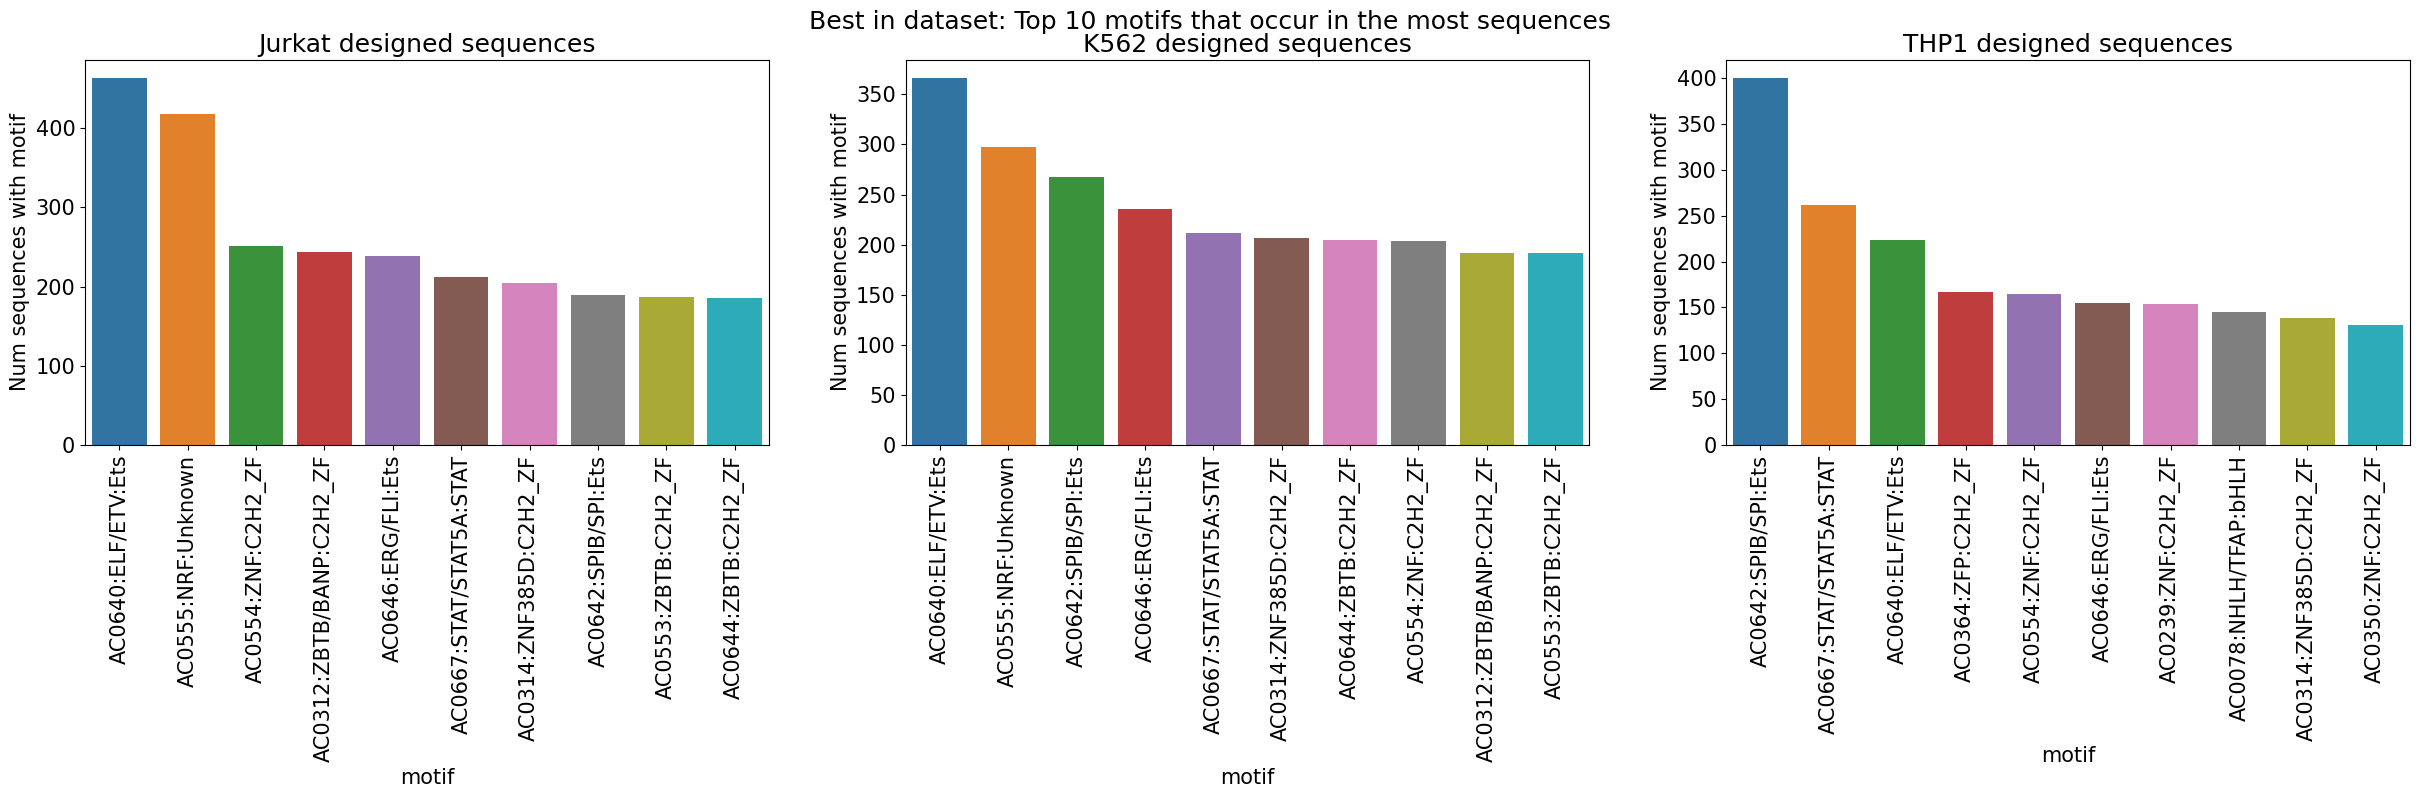

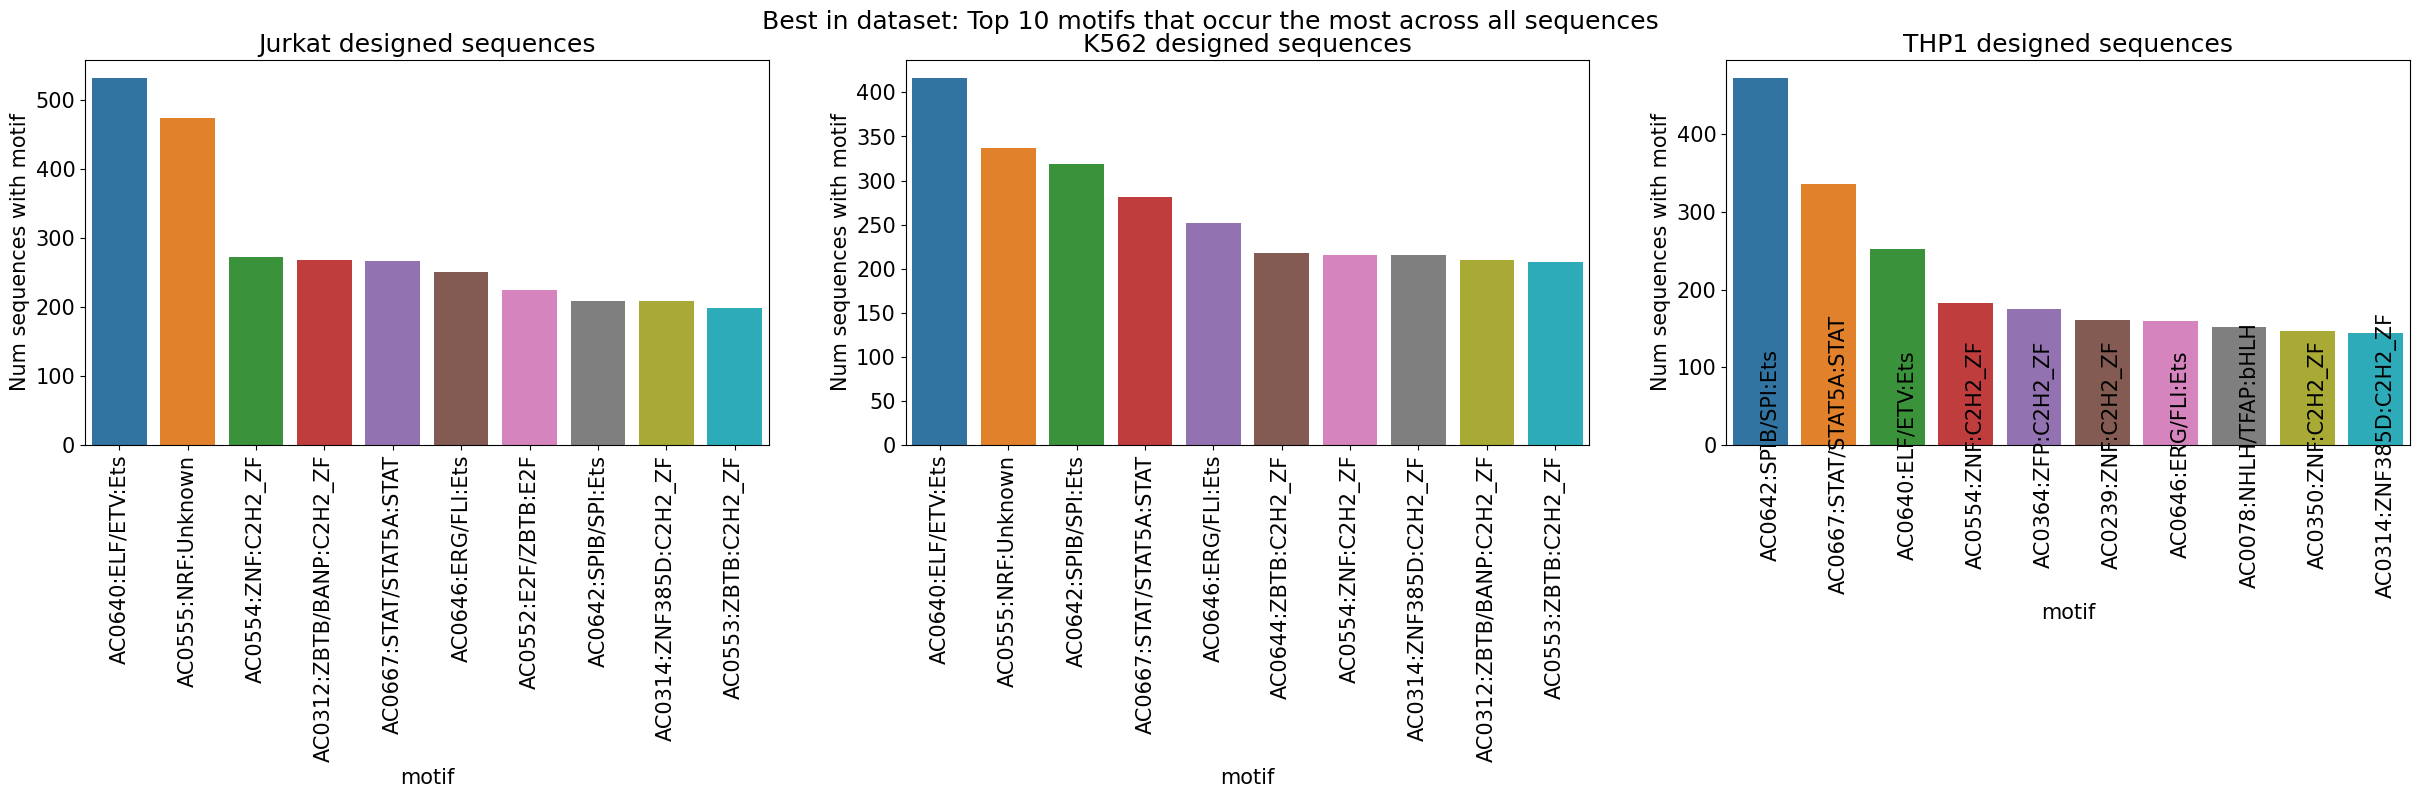

motif_tiling
jurkat
k562
thp1


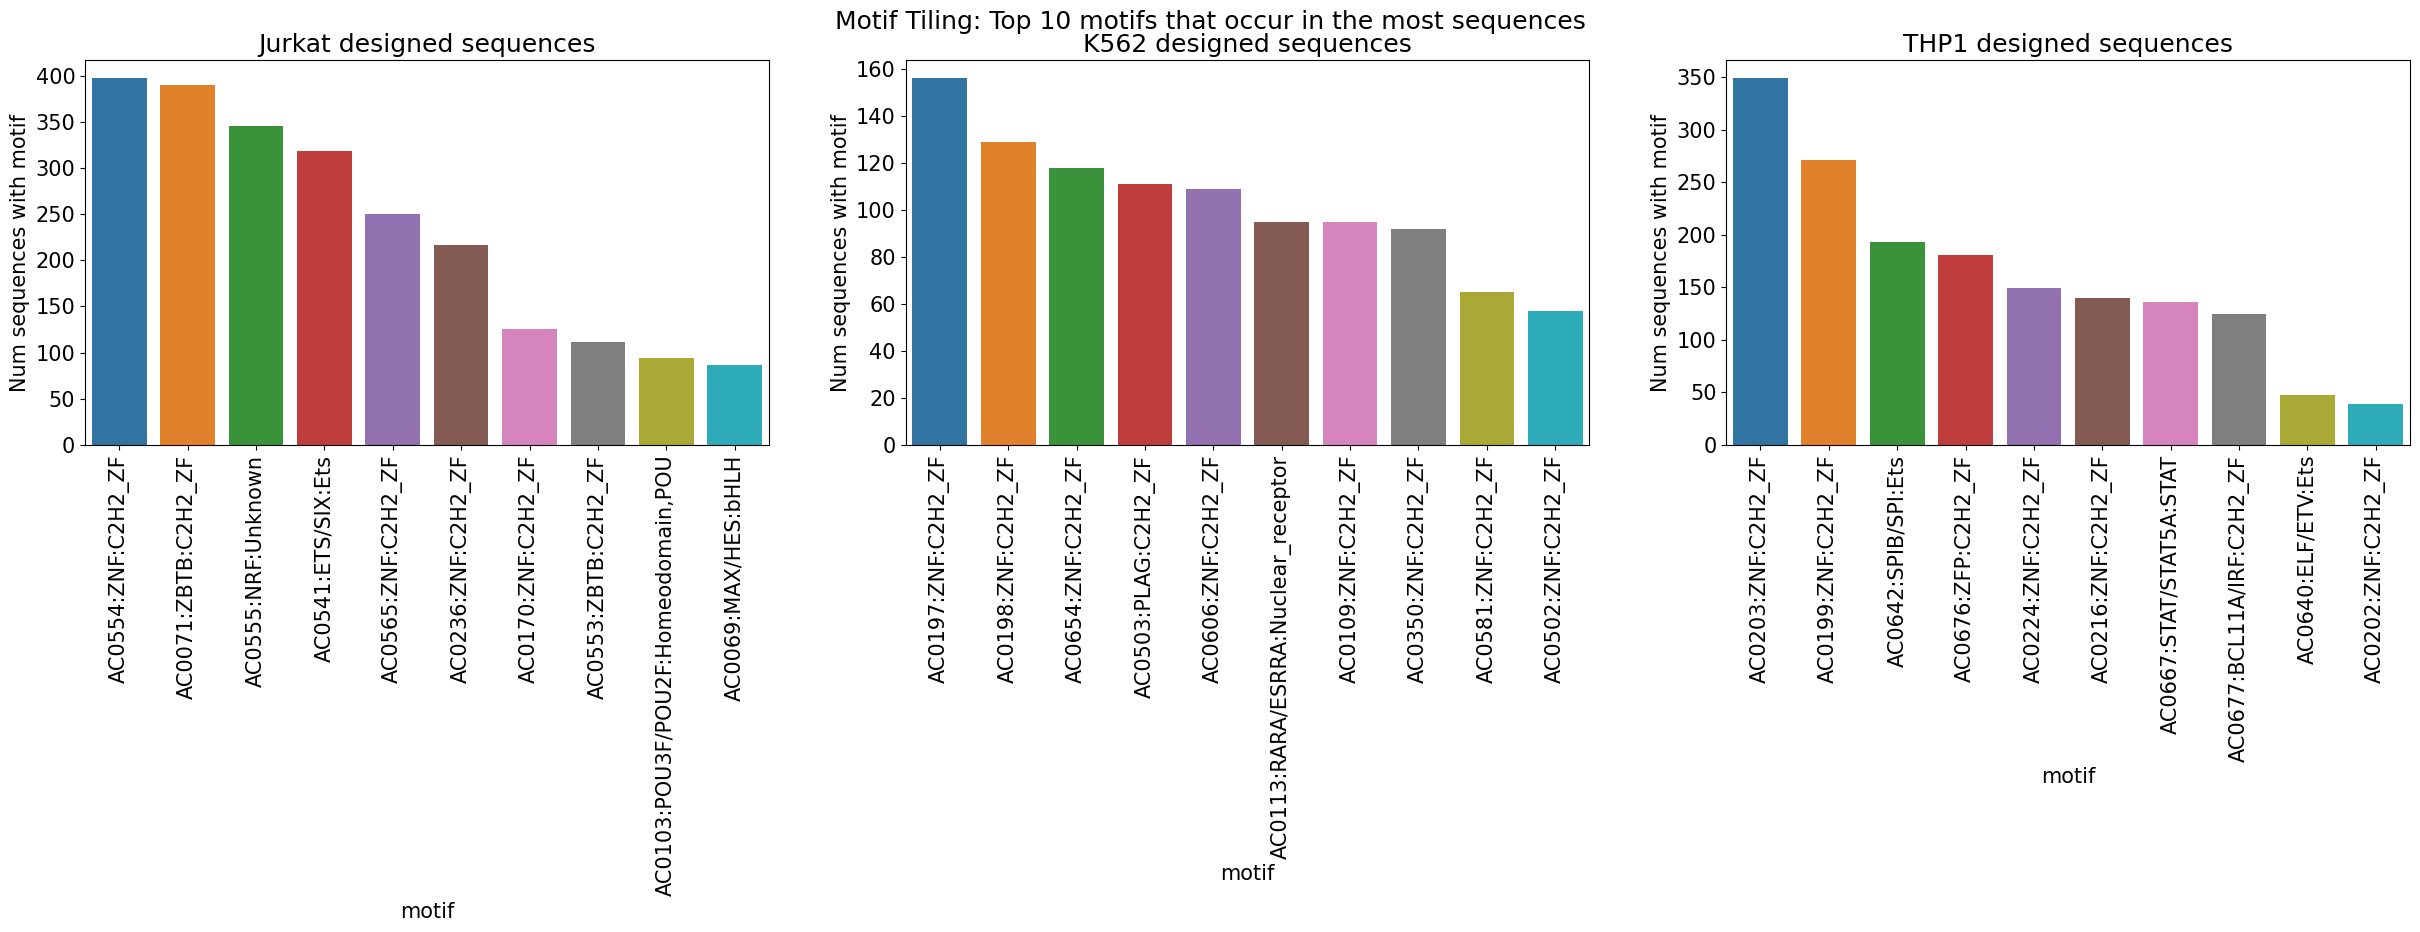

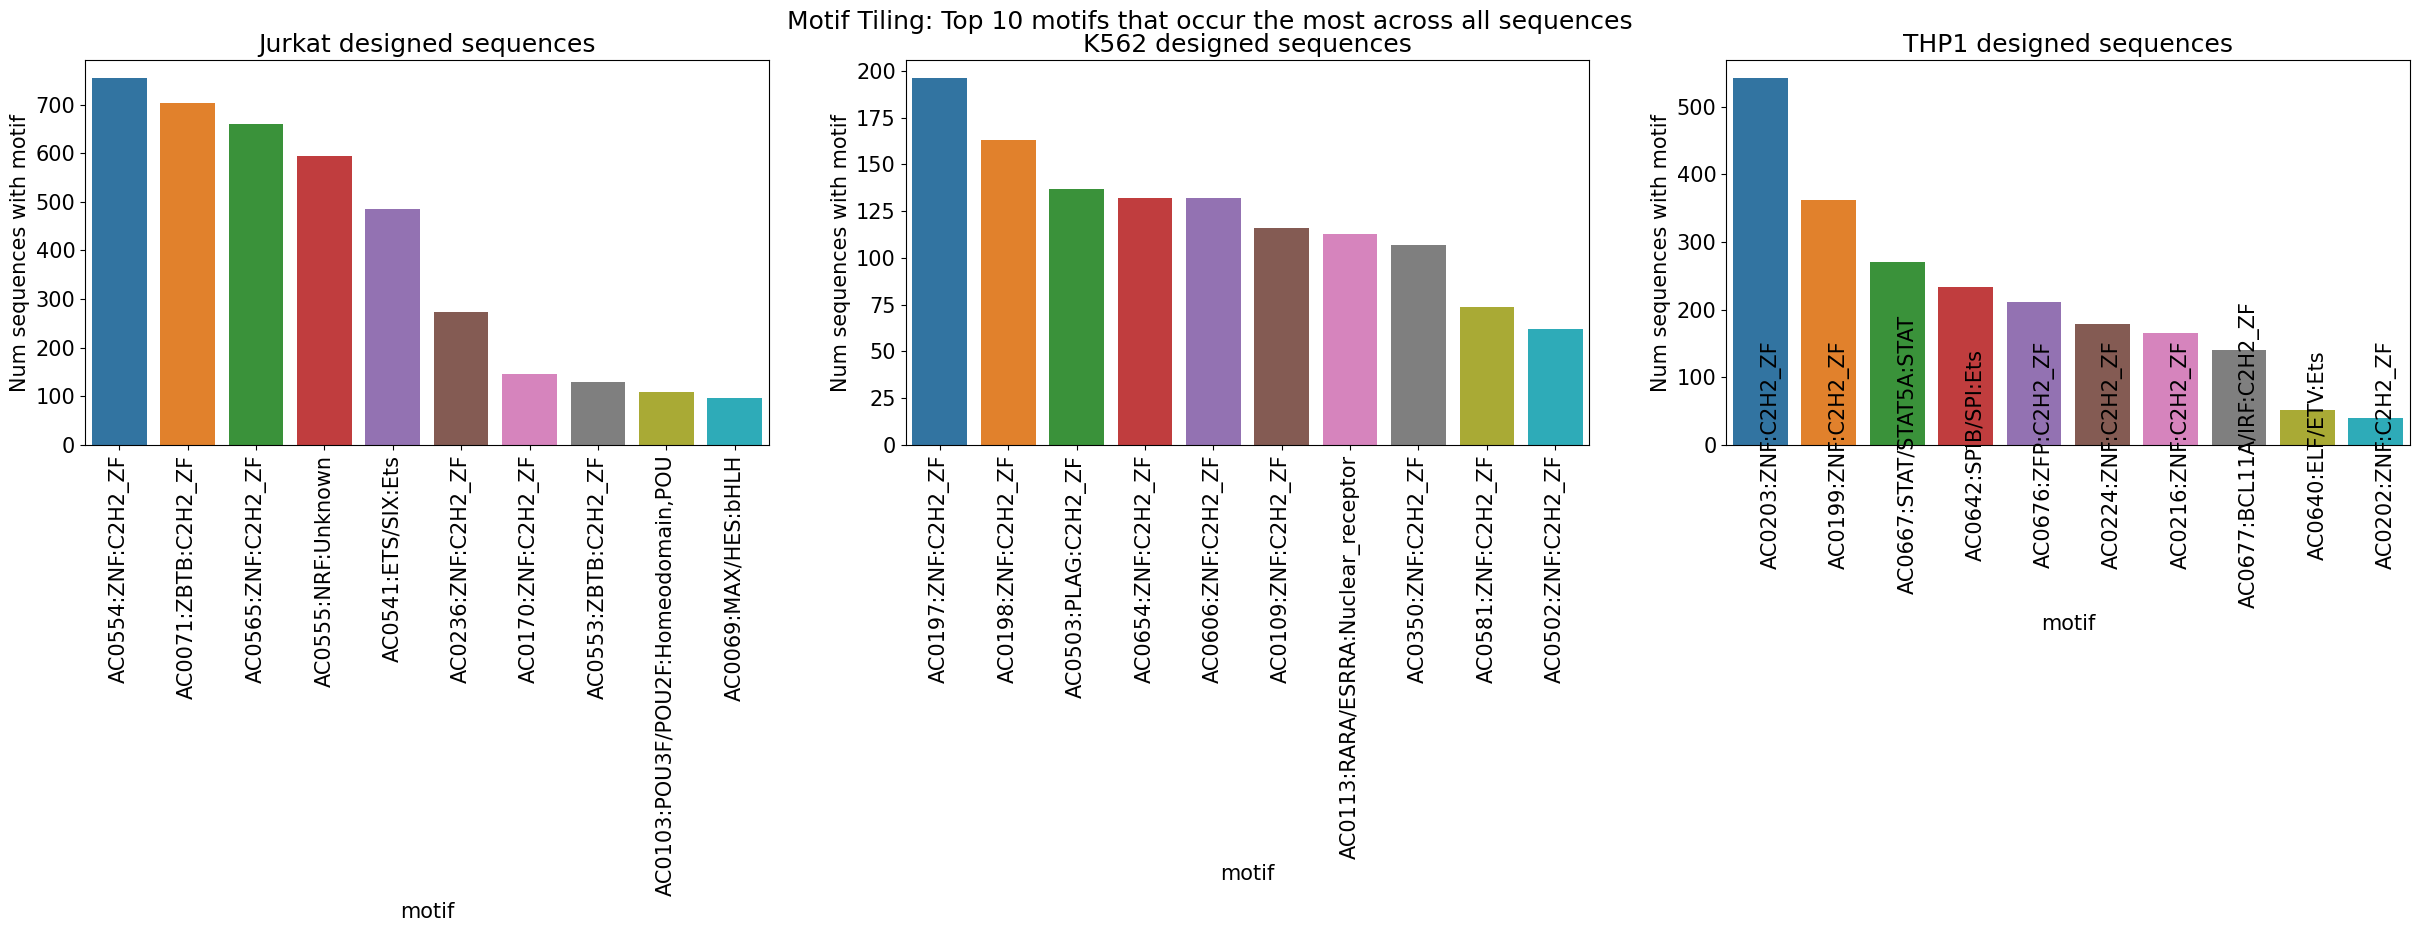

coms_final_design_v2
jurkat
k562
thp1


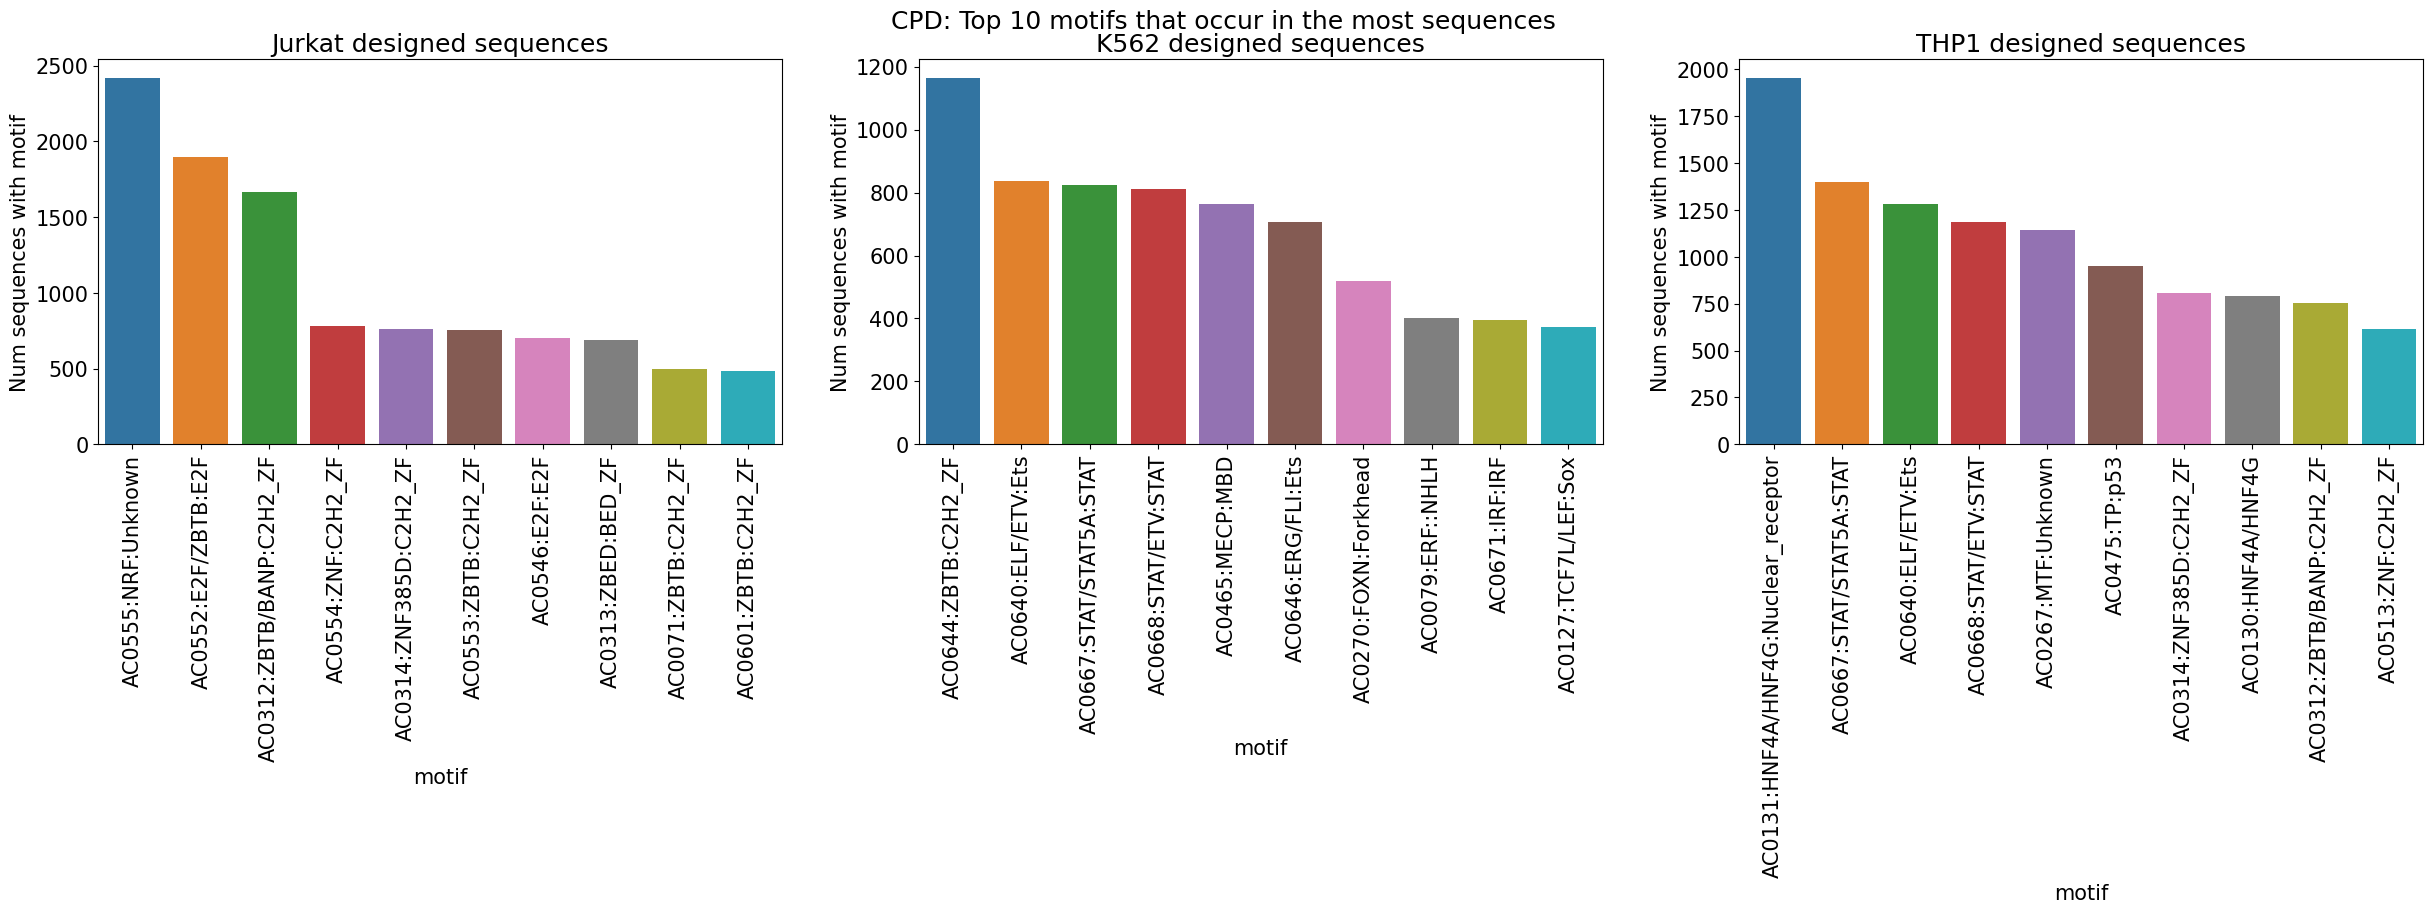

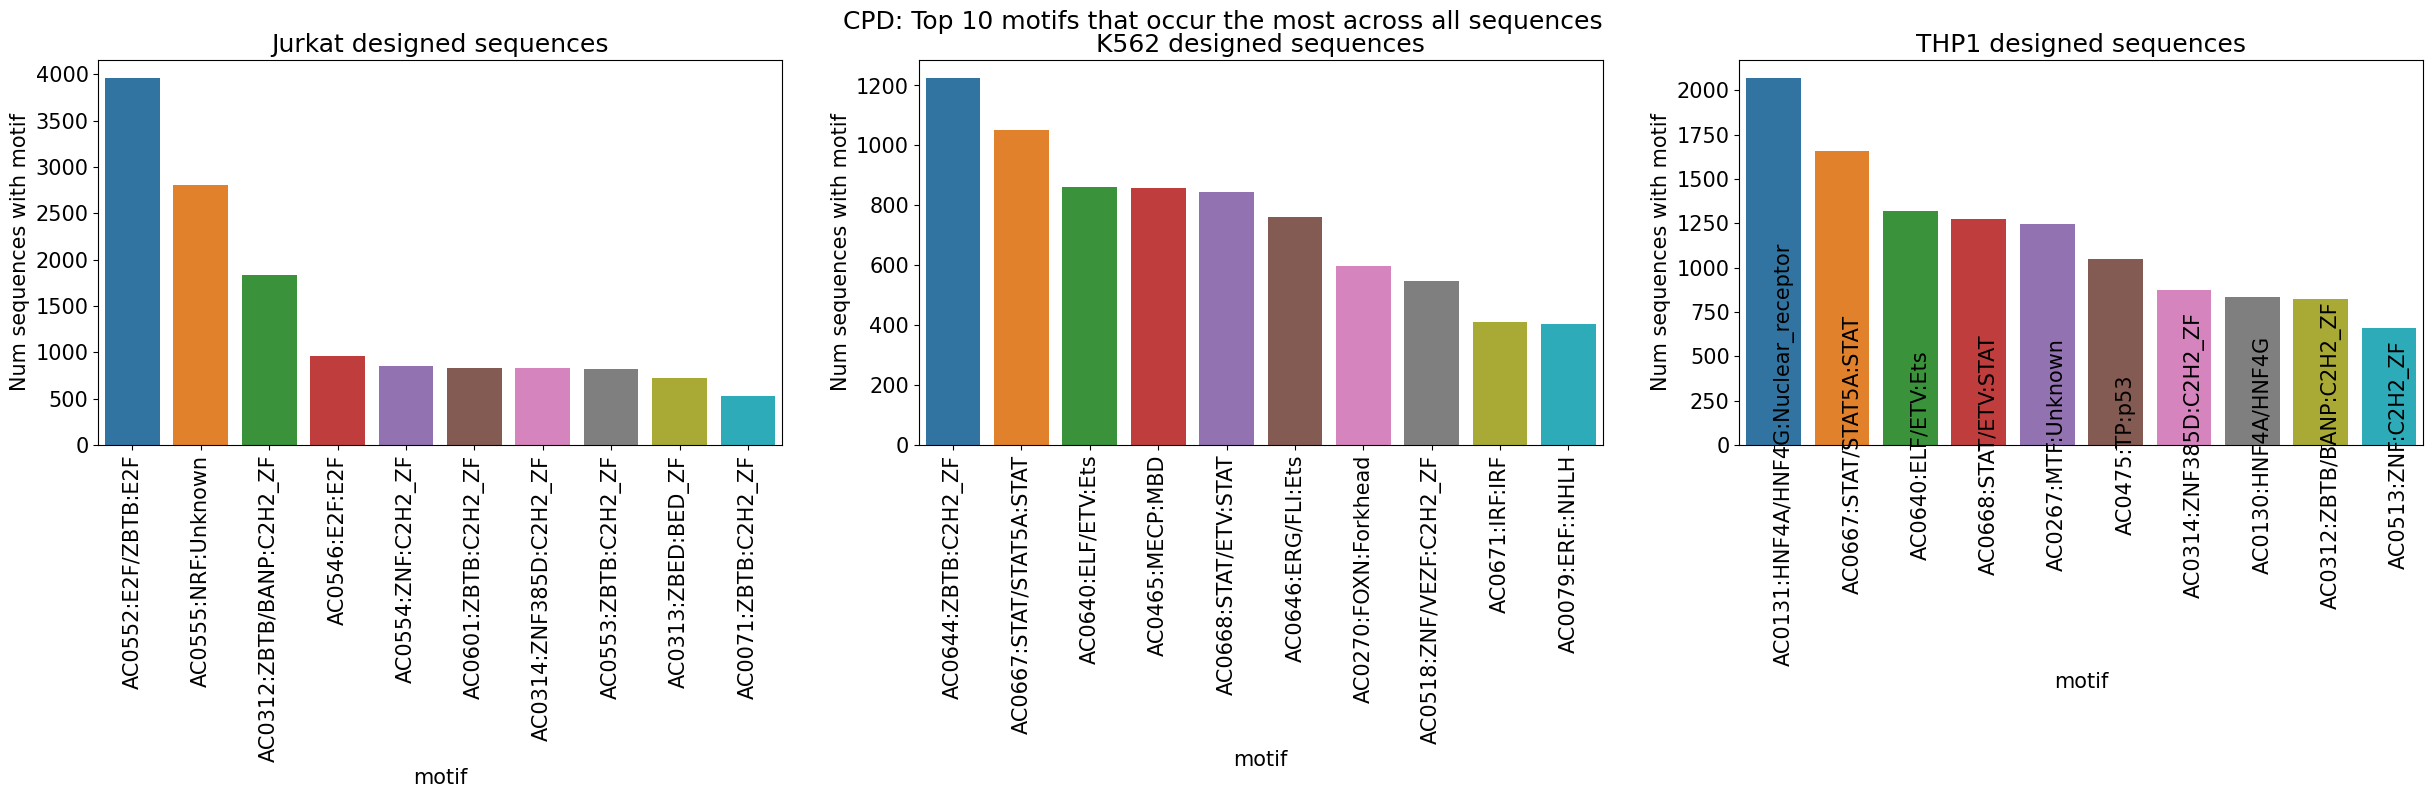

dens_final_design_v2_diversity_10.0
jurkat
k562
thp1


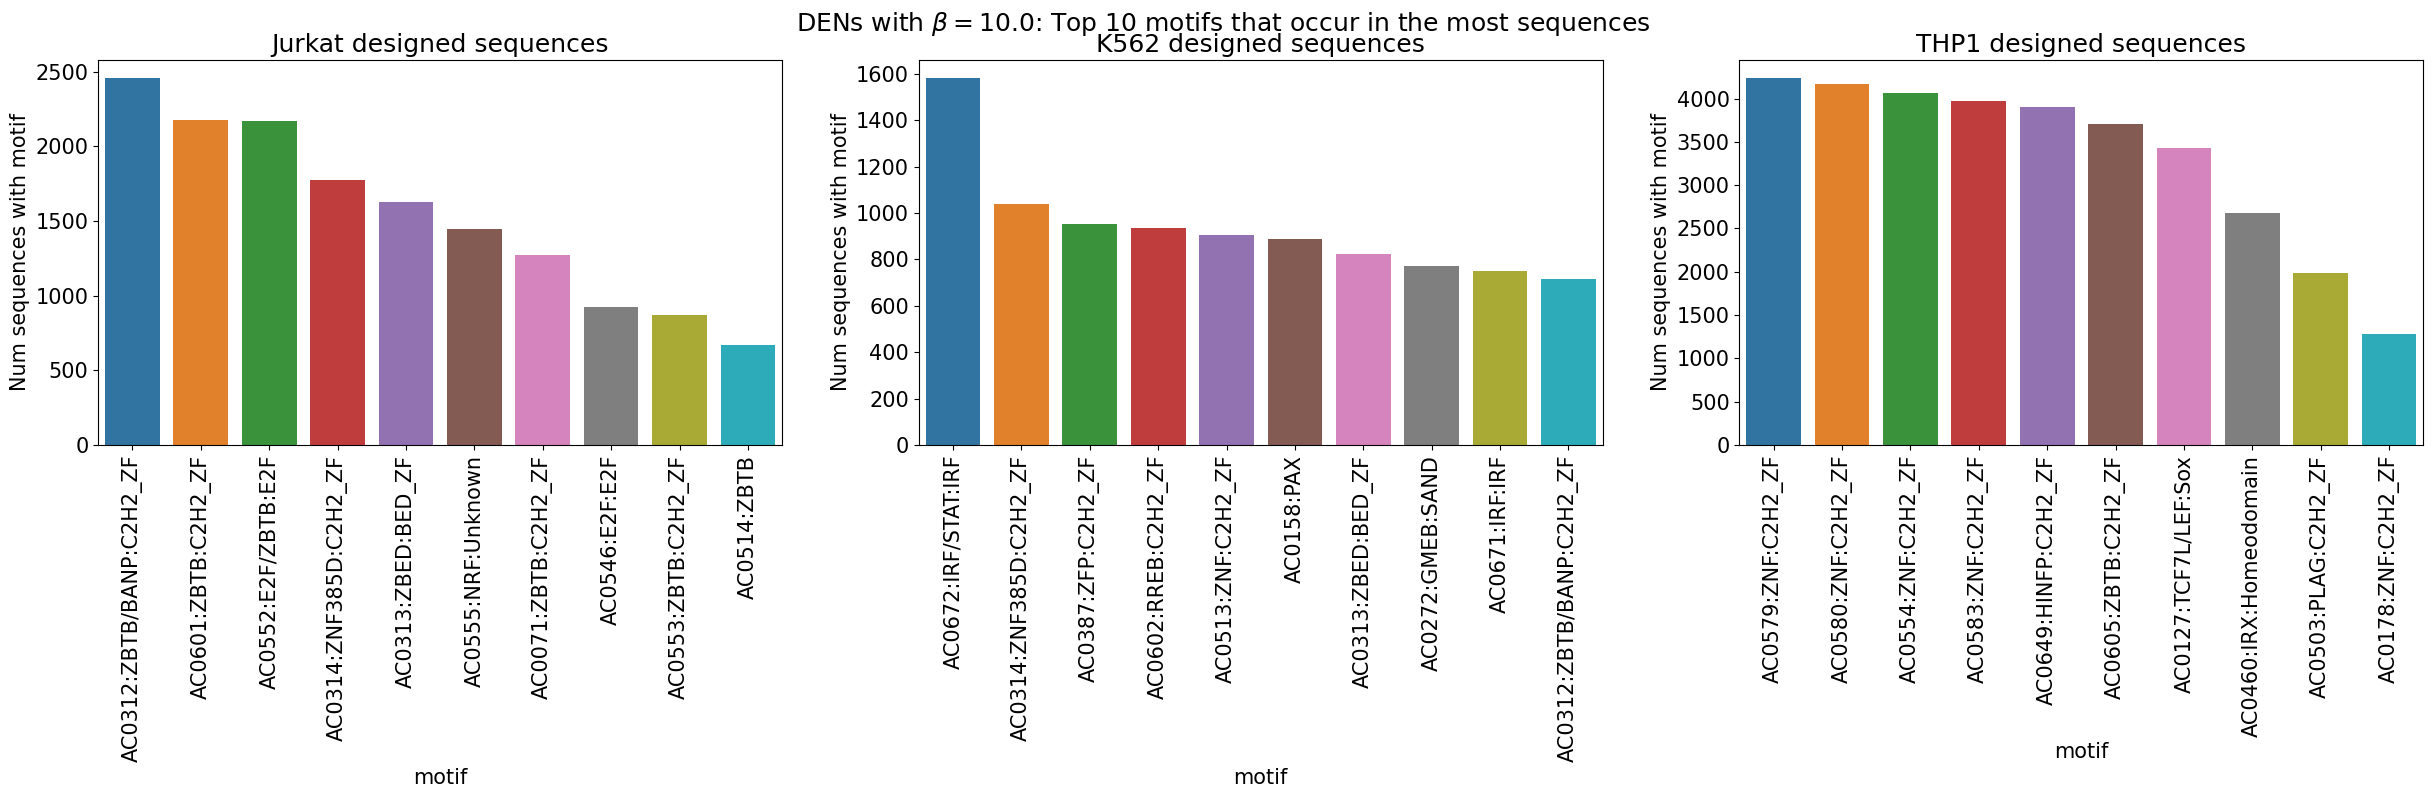

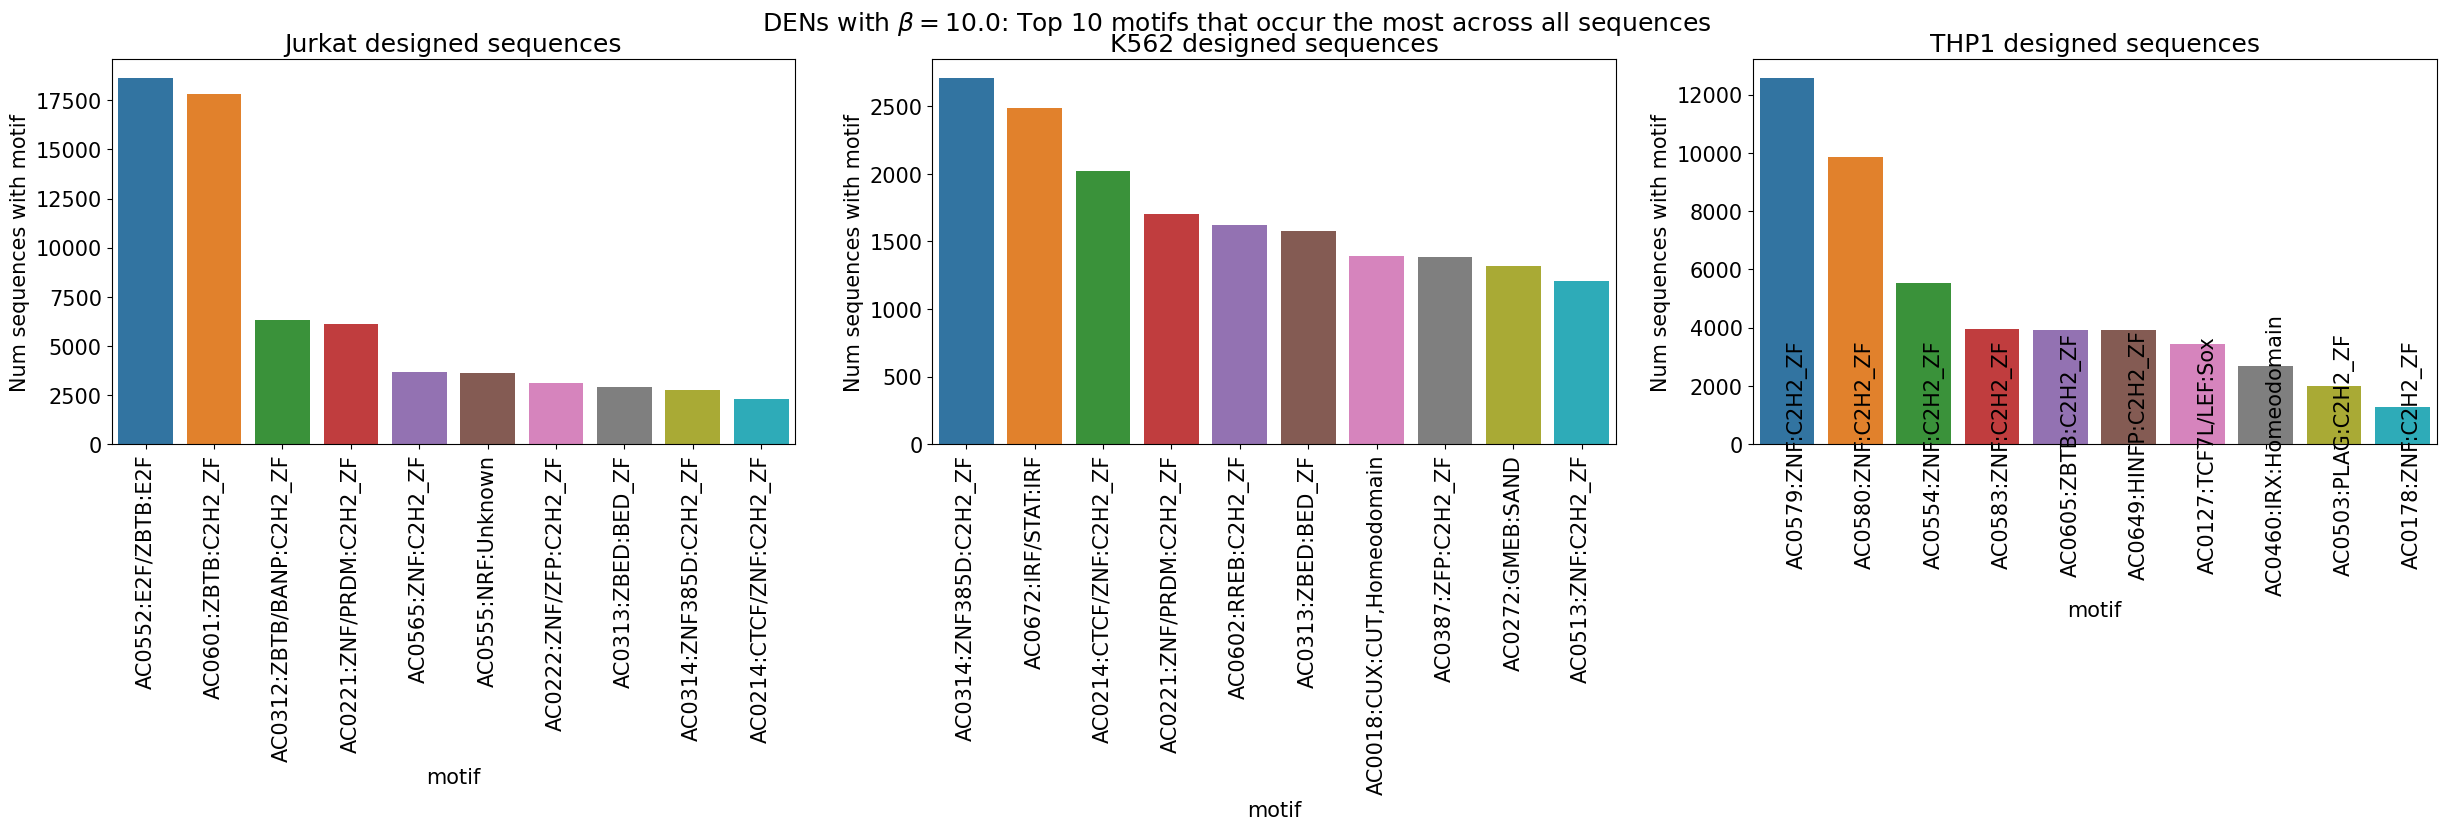

gradient_ascent_final_design_v2
jurkat
k562
thp1


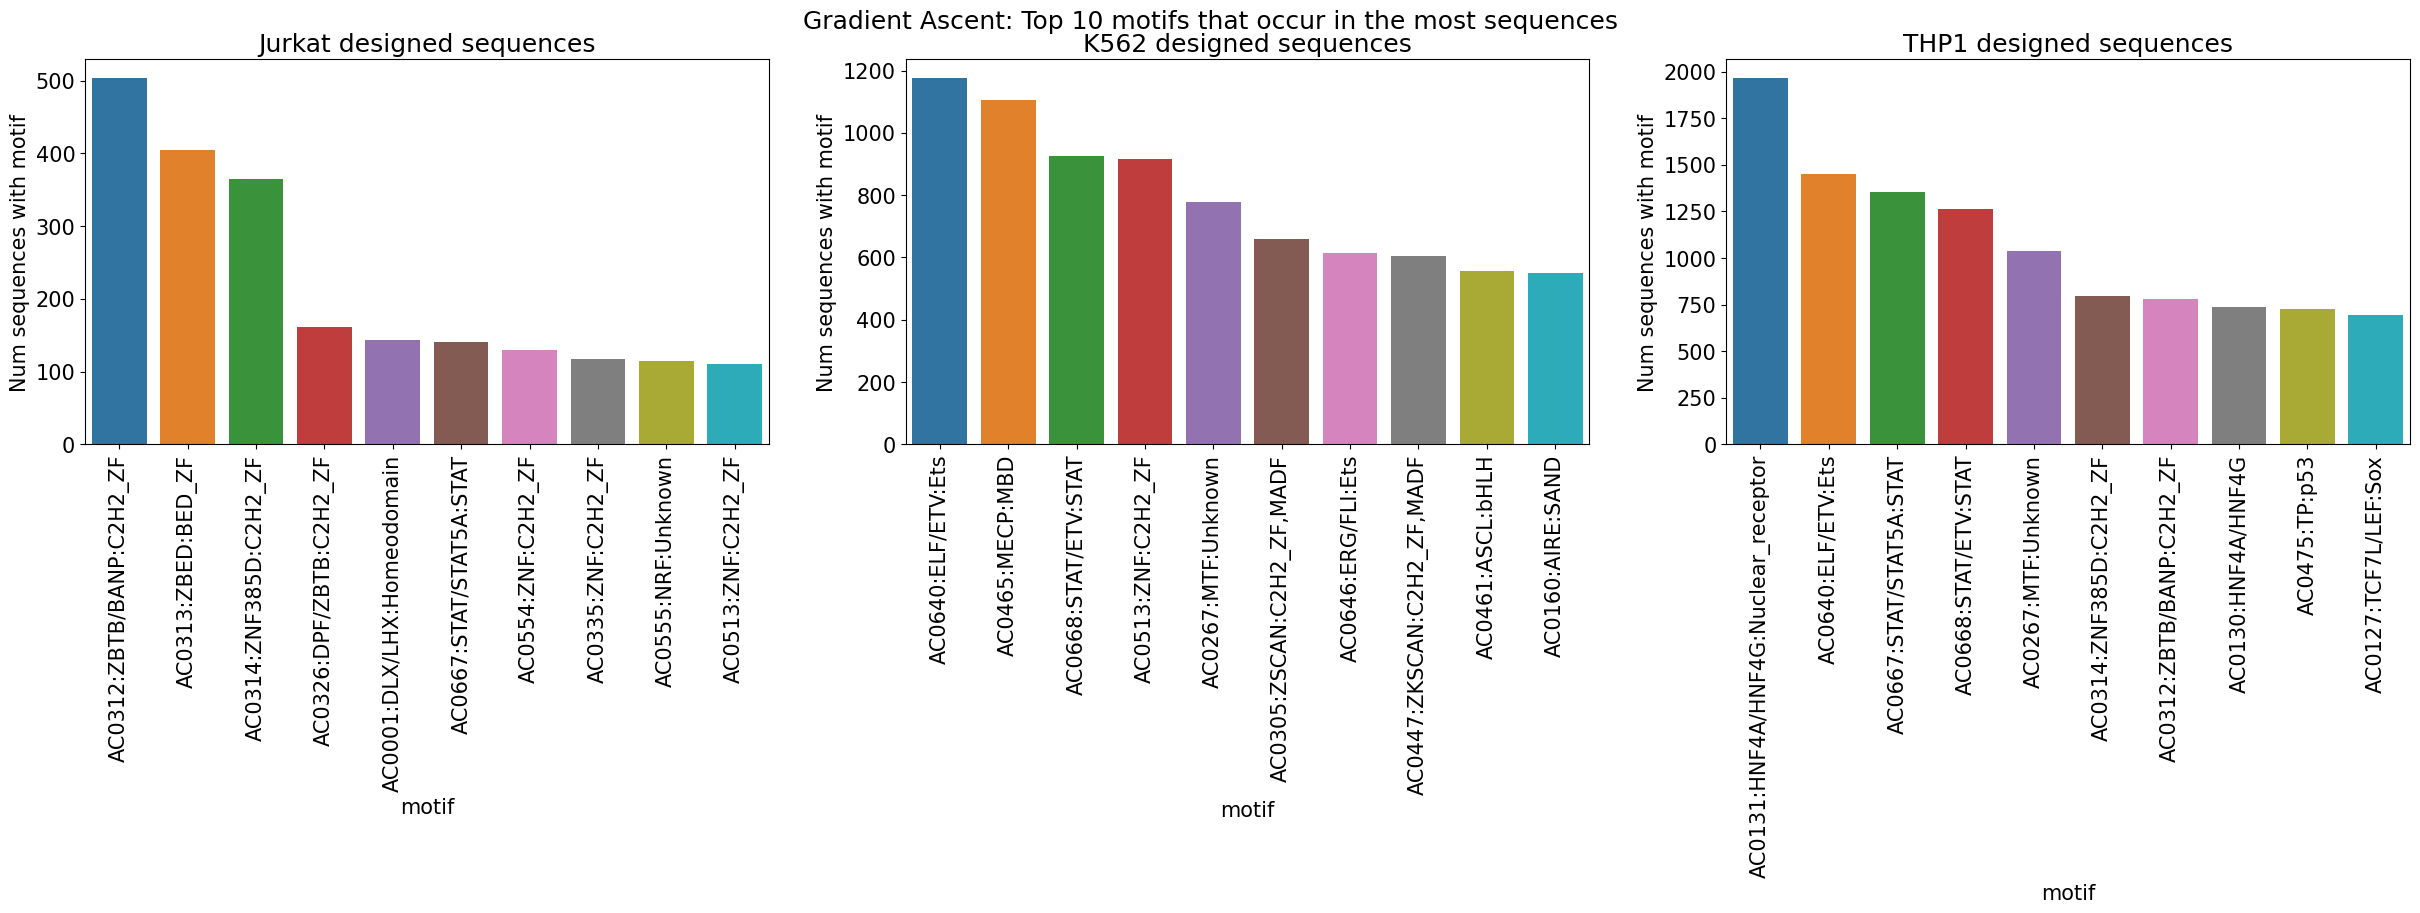

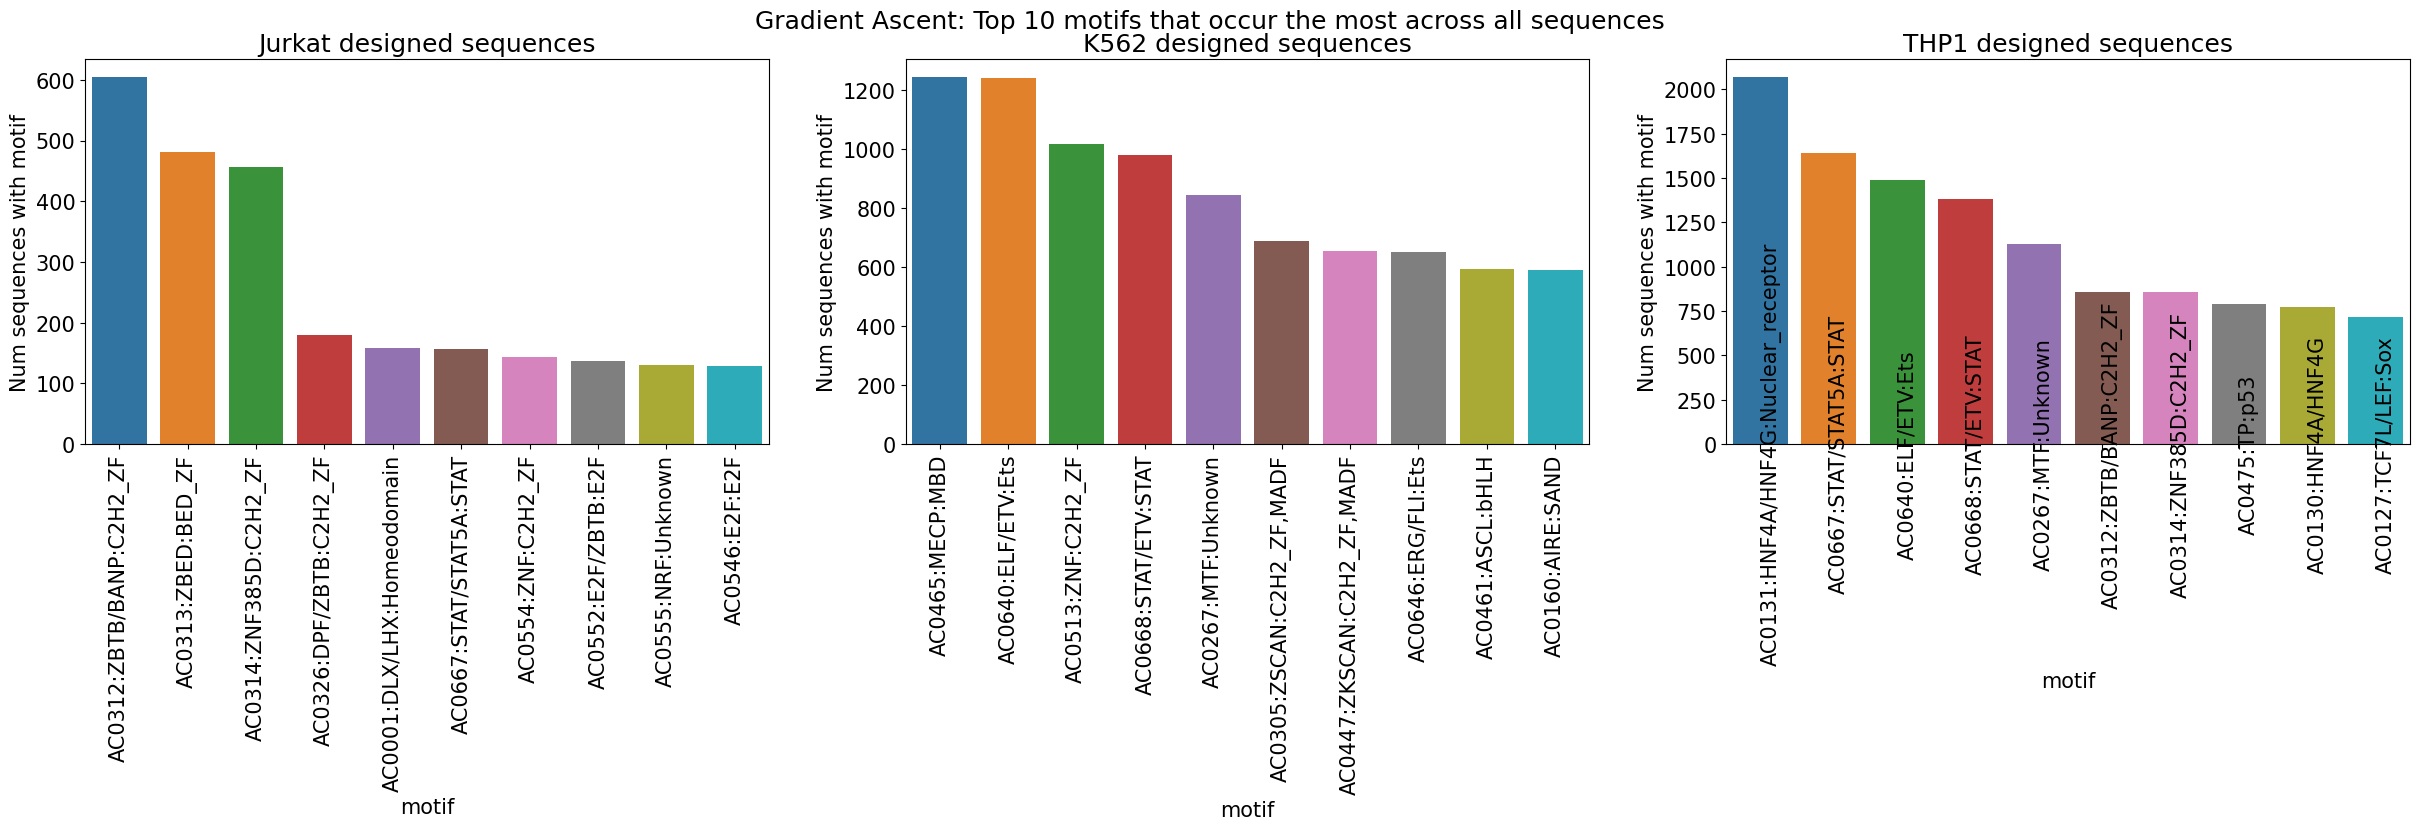

In [29]:
def format_str(s):
#     new = ""
#     for i in range(len(s)):
#         new += s[i]
#         if i % 10 == 0 and i != 0:
#             new += "\n"
    
    new = ":".join([i for i in s.split(":") if len(i) < 20])
    return new

methods = ["best_in_dataset",
           "motif_tiling", 
           "coms_final_design_v2", 
#            "dens_final_design_v2_diversity_0.0", 
#            "dens_final_design_v2_diversity_0.1",
#            "dens_final_design_v2_diversity_0.3",
#            "dens_final_design_v2_diversity_1.0",
#            "dens_final_design_v2_diversity_3.0",
           "dens_final_design_v2_diversity_10.0", 
           "gradient_ascent_final_design_v2"]

method_to_name = {"best_in_dataset": "Best in dataset",
                  "motif_tiling": "Motif Tiling", 
                  "coms_final_design_v2": "CPD", 
#                   "dens_final_design_v2_diversity_0.0": r"DENs with $\beta = 0.0$", 
#                   "dens_final_design_v2_diversity_0.1": r"DENs with $\beta = 0.1$",
#                   "dens_final_design_v2_diversity_0.3": r"DENs with $\beta = 0.3$",
#                   "dens_final_design_v2_diversity_1.0": r"DENs with $\beta = 1.0$",
#                   "dens_final_design_v2_diversity_3.0": r"DENs with $\beta = 3.0$",
                  "dens_final_design_v2_diversity_10.0": r"DENs with $\beta = 10.0$", 
                  "gradient_ascent_final_design_v2": "Gradient Ascent"}

name_map = {"jurkat": "Jurkat", "k562": "K562", "thp1": "THP1"}
plt.rcParams.update({'font.size': 15})
for i, method in enumerate(methods):
    print(method)
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 5))
    fig2, ax2 = plt.subplots(1, 3, figsize=(30, 5))
    
    for p, cell in enumerate(["jurkat", "k562", "thp1"]):
        print(cell)
        
        try:
            df = pd.read_csv(os.path.join(known_motif_analysis_results_dir, f"{method}_{cell}.gtf"), sep="\t", skiprows=5, index_col=None, header=None)
        except:
            continue
            
        motif_occurrences = {}
        
        for j in range(len(df)):
            row = df.iloc[j]
            motif_info = row[8]
            motif_name = motif_info.split()[1][1:-1]
            
            if motif_name not in motif_occurrences:
                motif_occurrences[motif_name] = []
            
            motif_occurrences[motif_name].append(row[0])
            
        motif_df = {}
        motif_df["motif"] = []
        motif_df["num_seqs_with_motif"] = []
        motif_df["num_total_occurrences"] = []
        
        for m in motif_occurrences:
            motif_df["motif"].append(m)
            motif_df["num_seqs_with_motif"].append(len(set(motif_occurrences[m])))
            motif_df["num_total_occurrences"].append(len(motif_occurrences[m]))
            
        motif_df = pd.DataFrame(motif_df)
        
        sns.barplot(data=motif_df.sort_values(by="num_seqs_with_motif", ascending=False).head(10), 
                    x="motif", y="num_seqs_with_motif", ax=ax[p])
        ax[p].set_xticklabels([format_str(s) for s in motif_df.sort_values(by="num_seqs_with_motif", ascending=False).head(10)["motif"]], 
                              rotation = 90)
        ax[p].set_title(f"{name_map[cell]} designed sequences")
        ax[p].set_ylabel("Num sequences with motif")
        
        sns.barplot(data=motif_df.sort_values(by="num_total_occurrences", ascending=False).head(10), 
                    x="motif", y="num_total_occurrences", ax=ax2[p])
        ax2[p].set_xticklabels([format_str(s) for s in motif_df.sort_values(by="num_total_occurrences", ascending=False).head(10)["motif"]], 
                               rotation = 90)
        ax2[p].set_title(f"{name_map[cell]} designed sequences")
        ax2[p].set_ylabel("Num sequences with motif")

    fig.suptitle(f"{method_to_name[method]}: Top 10 motifs that occur in the most sequences")
    fig2.suptitle(f"{method_to_name[method]}: Top 10 motifs that occur the most across all sequences")
    plt.xticks(wrap=True)
    plt.show()